# SETUP

### IMPORTS


In [5]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import time

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

print(int(time.time()))

1531616305


### MISC SETUP

In [3]:
batch_size = 64*6
NOISE_DIM = 100
noise_size = NOISE_DIM
image_size = 64 # image size must be divisible by 4
normalize = False

### DATA

In [4]:
X_train = None
X_display = None

def load_data():
    global X_train
    global X_display
    
#     X_train = np.loadtxt("raw/28-data.txt")
    X_train = np.loadtxt("data/marina-raw/{}-data.txt".format(str(image_size)))
    #28-data.txt has 28x28
    #36-data.txt has 36x36 etc
    #contain 28, 36, 48
    X_display = X_train.copy()
    
    #pre-processing
        
    X_train_temp = X_train.reshape(-1, 3)
    X_train_mean = np.mean(X_train_temp, axis=0)
    X_train_std = np.std(X_train_temp, axis=0)
    X_train = X_train / 255
    if normalize:
        X_train = (X_train_temp - X_train_mean) / X_train_std #optional -- normalize data (now can be negative)
    X_train = X_train.reshape(-1, image_size, image_size, 3)
    
    X_train = torch.from_numpy(X_train)

    X_train = X_train.permute(0, 3, 1, 2) # becomes N x C x H x W
#     print(X_train)
    print(X_train.shape)
    
load_data()

torch.Size([2230, 3, 64, 64])


### DISPLAY SETUP

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images.resize(images.shape[0], 3, image_size, image_size)
    images = torch.from_numpy(images)
    images = images.permute(0, 2, 3, 1) # becomes N x H x W x C
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(2*sqrtn, 2*sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.2, hspace=0.2)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([image_size, image_size, 3]), vmin=0,vmax=255)
    return 

### DISPLAY DATA

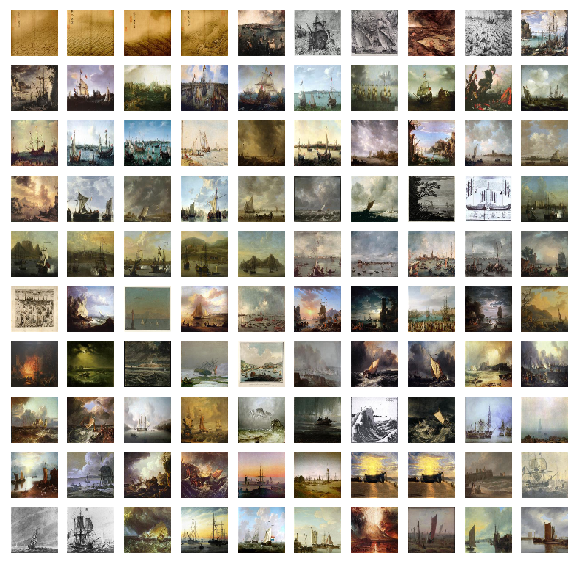

In [6]:
X_display.resize(batch_size, image_size, image_size, 3)

images = X_display[0:100]
images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)

sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

fig = plt.figure(figsize=(sqrtn, sqrtn))
gs = gridspec.GridSpec(sqrtn, sqrtn)
gs.update(wspace=0.2, hspace=0.2)

for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([image_size, image_size, 3]) / 255, vmin=0,vmax=255)


plt.show()

### HELPER FUNCTIONS

In [7]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
#     rand = torch.rand([batch_size, dim]) * 2 - 1
    rand = torch.rand([batch_size, dim, 1, 1]) * 2 - 1
    return rand
#     return torch.rand([batch_size, 1, image_size, image_size]) * 2 - 1

def sample_noise_square(batch_size, dim):
    rand = torch.rand([batch_size, dim, dim]) * 2 - 1
    return rand

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

### CPU OR GPU

In [8]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# GAN

### SETUP FUNCTIONS

In [9]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    
    sq_real_loss = (scores_real - 1) ** 2
    sq_fake_loss = (scores_fake ** 2)
    
    
    loss = sq_real_loss.mean() / 2 + sq_fake_loss.mean() / 2
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    sq_loss = (scores_fake - 1) ** 2
    loss = sq_loss.mean() / 2
    return loss

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    fake = logits_fake.type(dtype)
    real = logits_real.type(dtype)
    true_fake_labels = Variable(torch.zeros_like(logits_fake)).type(dtype)
    true_real_labels = Variable(torch.ones_like(logits_fake)).type(dtype)
    loss_fake = bce_loss(fake, true_fake_labels)
    loss_real = bce_loss(real, true_real_labels)
    loss = loss_fake + loss_real
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    true_labels = Variable(torch.ones_like(logits_fake)).type(dtype)
    fake = logits_fake.type(dtype)

    loss = bce_loss(fake, true_labels)
    
    return loss

In [10]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999)) #5e-4 good for 32
    return optimizer

In [11]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=50, 
              batch_size=100, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    
    X_train_batches = []
    batch_count = 0
    while True:
        if (batch_count + 1) * batch_size > X_train.shape[0]: 
            break
        else: 
            X_train_batches.append(X_train[batch_count*batch_size:(batch_count+1)*batch_size])
        batch_count += 1
    
    
    for epoch in range(num_epochs):
        for x_basic in X_train_batches:
#             x = X_train
            if len(x) != batch_size:
                continue
    #         if iter_count % 2 == 0:
            # add some noise
        
            noise = torch.rand_like(x) * 2 - 1 # now is from -1 to 1
            scalar = 1 / (iter_count * 10)
            x = x_basic + noise*scalar
    
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(real_data).type(dtype) / 2 + 0.5

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach() 
            if not normalize:
                fake_images = fake_images / 2 + 0.5
            logits_fake = D(fake_images.view(batch_size, 3, image_size, image_size)) / 2 + 0.5

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()



            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            if not normalize:
                fake_images = fake_images / 2 + 0.5

            gen_logits_fake = D(fake_images.view(batch_size, 3, image_size, image_size)) / 2 + 0.5
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                if normalize:
                    imgs_numpy = imgs_numpy / 2 + 0.5
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
                print()
                print()
#             if (iter_count % (2*show_every) == 0):
#                 torch.save(G.state_dict(), "checkpoints/G_80_710_{}.pt".format(iter_count))
            iter_count += 1
    return G

### DISCRIMINATOR AND GENERATOR

In [ ]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
#     ndf = 32 # good for 32
#     ndf = 40 # good for 64?

    ndf = 45
    s = int((image_size/4) - 3)
#     return nn.Sequential(
#         ########################### 
#         ######### TO DO ###########
#         ###########################
#         Unflatten(batch_size, 3, image_size, image_size),
#         nn.Conv2d(3, 32, 5),
#         nn.LeakyReLU(0.01, inplace=True),
#         nn.MaxPool2d(2, stride=2),
#         nn.Conv2d(32, 64, 5),
#         nn.LeakyReLU(0.01, inplace=True),
#         nn.MaxPool2d(2, stride=2),
#         Flatten(),
#         nn.Linear(s*s*64, s*s*64), # is __ x __ x 64 where __ is f1(f1(image_size)) where f1(x) = x/2-2
#         nn.Linear(s*s*64, 1)
#     )
    return nn.Sequential(
        ########################### 
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 3, image_size, image_size),
        nn.Conv2d(3, ndf, 4, stride=2, padding=1), #halves the size (now 16)
        nn.BatchNorm2d(ndf),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1), #halves the size (now 8)
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1), #halves the size (now 4)
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1), #halves the size (now 2)
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf*8, ndf*16, 4, stride=2, padding=1), #halves the size (now 2)
        nn.BatchNorm2d(ndf*16),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(ndf*16, 1, 4, stride=2, padding=1), #64
#         nn.Conv2d(ndf*16, 1, 4, stride=2, padding=0), #128
        nn.Tanh(),
#         nn.Sigmoid(),
        Flatten()
    )

data = Variable(X_train[:batch_size]).type(dtype)
print(data.size())
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([384, 3, 64, 64])


In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    s = int(image_size/4)
#     ngf = 64 # good for 32
#     ngf = 100 #good for 64?
    ngf = 100
    
#     return nn.Sequential( # update
#         #Flatten(),
#         nn.Linear(noise_dim, 1024),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(1024),
#         nn.Linear(1024, s*s*128), # becomes 1024 to __ x __ x 128 where __ is image_size / 4
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(s*s*128),
#         Unflatten(batch_size, 128, s, s),
#         nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm2d(64),
#         nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
#         nn.Tanh(),
#         Flatten()
#     )

    return nn.Sequential( # update
        # start is batch x noise_dim x 1 x 1
        nn.ConvTranspose2d(noise_dim, ngf*16, 4, stride=2, padding=1), #64
#         nn.ConvTranspose2d(noise_dim, ngf*16, 4, stride=4, padding=0), #128

        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*16),
        
        
        nn.ConvTranspose2d(ngf*16, ngf*8, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*8),
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*4),
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*2),
        nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf),     
        nn.ConvTranspose2d(ngf, 3, 4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = Variable(torch.randn(batch_size, NOISE_DIM, 1, 1)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

### ACTUAL TRAINING LOOP

In [ ]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)


In [ ]:

G_ac = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, 
                 num_epochs=1000, show_every=250, batch_size=batch_size, noise_size=noise_size)


In [ ]:
G_64 = G_ac
#G_best = G_ac
# # print(G_64)
timestamp = int(time.time())
torch.save(G_64.state_dict(), "saved-models/{}.pt".format(str(timestamp)))

In [ ]:
# G_ac = G_DC
# G_ac.load_state_dict(torch.load('saved-models/G_60_782018.pt'))

g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
fake_images = G_ac(g_fake_seed)
fake_images = fake_images.resize(batch_size, 3, image_size, image_size).type(dtype) / 2 + 0.5
    
imgs_numpy = fake_images.data.cpu().numpy()
images = imgs_numpy[0:4] #shape is 1 x 3*image_size*image_size


images.resize(images.shape[0], 3, image_size, image_size)
images = torch.from_numpy(images)
images = images.permute(0, 2, 3, 1) # becomes N x H x W x C
images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

fig = plt.figure(figsize=(6 * sqrtn, 6 * sqrtn))
gs = gridspec.GridSpec(sqrtn, sqrtn)
gs.update(wspace=0.2, hspace=0.2)

for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([image_size, image_size, 3]), vmin=0,vmax=255)


plt.show()